# Making .gif Visualization for Coherent Point Drift (CPD)

### This method shows the transformation steps the CPD algorithm take to move source points to their destinations.

Hannah Valenty

Import packages

In [1]:
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.font_manager as font_manager
from PIL import Image, ImageDraw
import imageio
import numpy as np

import json
from pathlib import Path
from typing import List, Tuple, Dict, Literal
from utils.annotations import BoundingBox
# CPD code modified to save intermediate point locations
from cpd_gif import deformable_registration, emregistration, utility

Read in sheet bounding boxes

In [2]:
def label_studio_to_bboxes(path_to_json_data: Path) -> List[BoundingBox]:
    """Loads data from LabelStudio's json format into BoundingBoxes."""
    json_data: List[Dict] = json.loads(open(str(path_to_json_data)).read())
    return {
        sheet_data['data']['image'].split("-")[-1]:[
            BoundingBox(
                category=label['value']['rectanglelabels'][0],
                left=label['value']['x']/100,
                top=label['value']['y']/100,
                right=label['value']['x']/100+label['value']['width']/100,
                bottom=label['value']['y']/100+label['value']['height']/100,
            )
            for label in sheet_data['annotations'][0]['result']
        ]
        for sheet_data in json_data
    }


data_path: Path = Path("..")/"data"
# updated landmarks JSON
landmark_new: Dict[str, List[BoundingBox]] = label_studio_to_bboxes(data_path/"intraop_document_landmarks.json")

Method to extract Bounding Box centers for source and destination sheets

In [4]:
def get_centers(src_bb: List, dst_bb: List):
    """Register points from input image to transform to destination

    Args:
        src_bb (List): Source bounding boxes
        dst_bb (List): Destination bounding boxes

    Returns:
        List: 2 lists of source and destination points
    """
    src_centers = []
    for i in range(len(src_bb)):
        src_centers.append(src_bb[i].center)
    # convert to numpy array to fit registration specifications
    src_np = np.asarray(src_centers) 

    # extract destination -- unified landmark sheet
    dst_centers = []
    for i in range(len(dst_bb)):
        dst_centers.append(dst_bb[i].center)
    # convert to numpy array to fit registration specifications
    dst_np = np.asarray(dst_centers)

    return src_np, dst_np

Select sheets from .json to visualize

In [5]:
src_test_bb = landmark_new['RC_0001_intraoperative.JPG']
dst_test_bb = landmark_new['unified_intraoperative_preoperative_flowsheet_v1_1_front.png']

Extract BB centers

In [6]:
src_c, dst_c = get_centers(src_test_bb, dst_test_bb)

Register sheets using updated code that saves intermediate point locations

In [7]:
def_reg = deformable_registration.DeformableRegistration(X=dst_c, Y=src_c, alpha=5.5, beta=5.5, w=0)
TY, _, set_motion = def_reg.register()

Image paths for plotting background options

In [9]:
rc1 = '../data/chart_images/RC_0001_intraoperative.JPG'
blank = 'blank.png'
unified = '../data/unified_intraoperative_preoperative_flowsheet_v1_1_front.png'

Method to produce intermediate point plots for .gif

In [ ]:
def gif_plots(set_motion: List, dst_center: List, fig_path, fig_name):

    img = np.asarray(Image.open(fig_path))

    # image scaling values
    DESIRED_IMAGE_WIDTH = img.shape[1] 
    DESIRED_IMAGE_HEIGHT = img.shape[0]

    # source points
    set_x, set_y = zip(*set_motion)
    # destination points
    dst_x, dst_y = zip(*dst_center)

    sx = [value * DESIRED_IMAGE_WIDTH for value in set_x]
    sy = [value * DESIRED_IMAGE_HEIGHT for value in set_y]

    dx = [value * DESIRED_IMAGE_WIDTH for value in dst_x]
    dy = [value * DESIRED_IMAGE_HEIGHT for value in dst_y]

    font = font_manager.FontProperties(family='Century')

    plt.imshow(img)
    plt.scatter(sx, sy, s=0.7, c='red', label='Source')
    plt.scatter(dx, dy, s=0.7, c = "blue", label='Destination')
    plt.legend(loc=4, markerscale=4, prop=font) # outside: bbox_to_anchor=(1.04, 1), loc='upper left'
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    #plt.title('Bounding box center point clouds', **csfont)
    plt.savefig(f'./gif_img/gif_plot_{fig_name}', dpi=1000)

    return plt.show()

Loop through points, plot, and save to folder

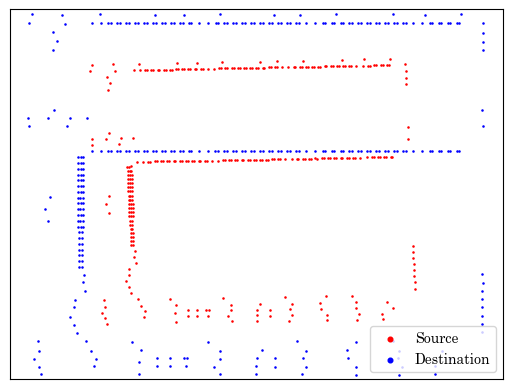

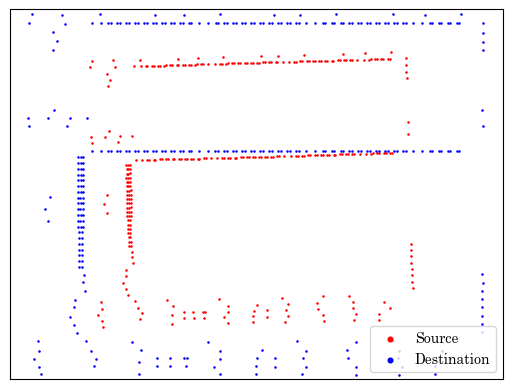

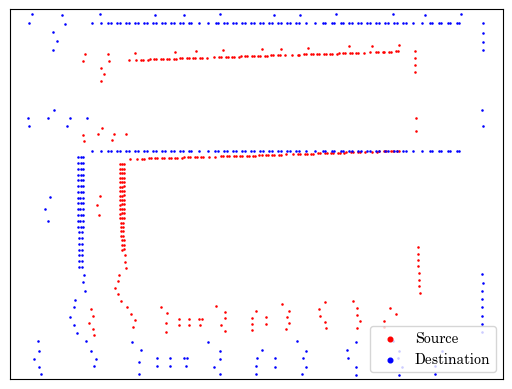

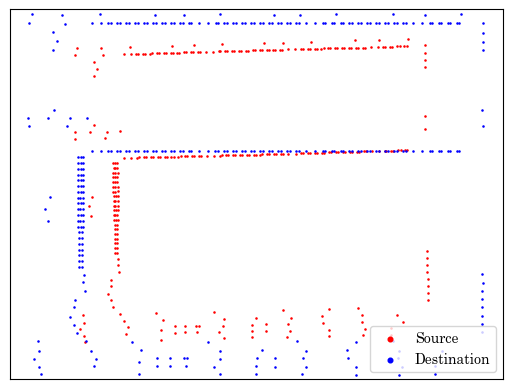

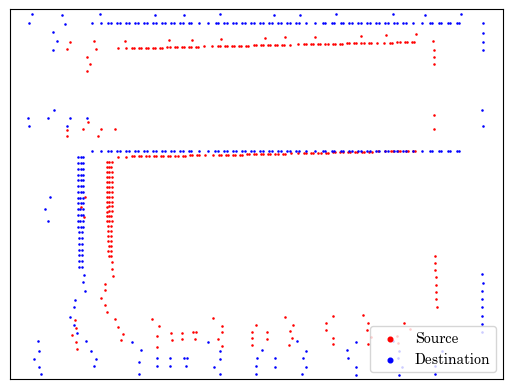

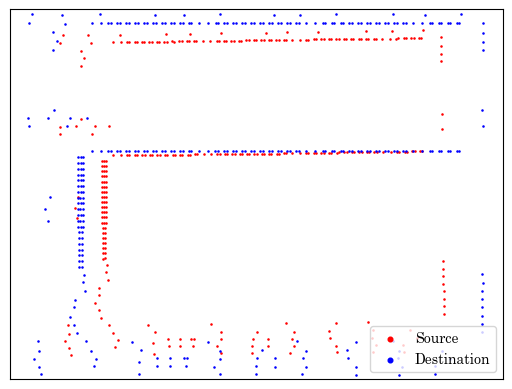

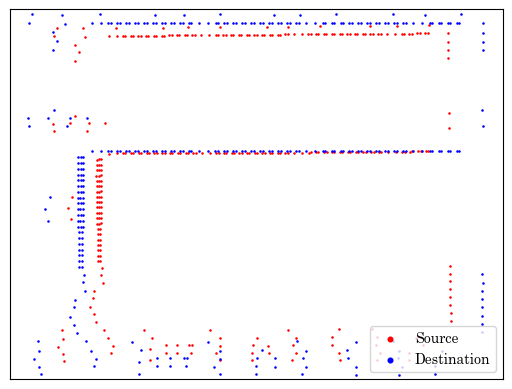

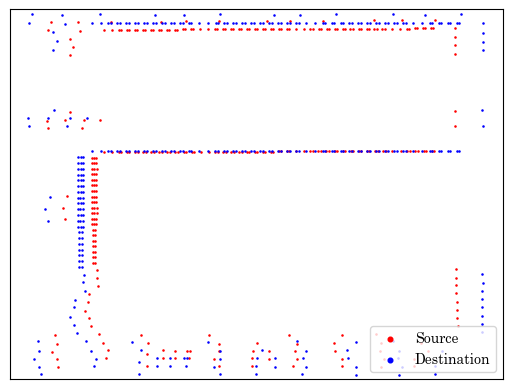

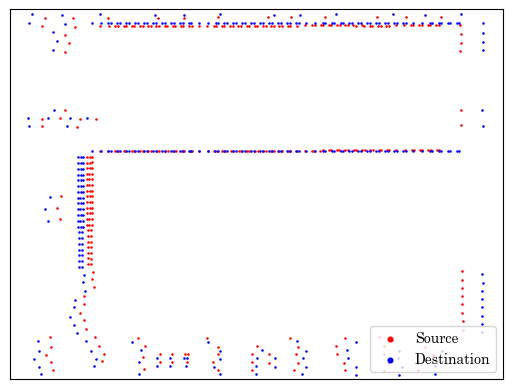

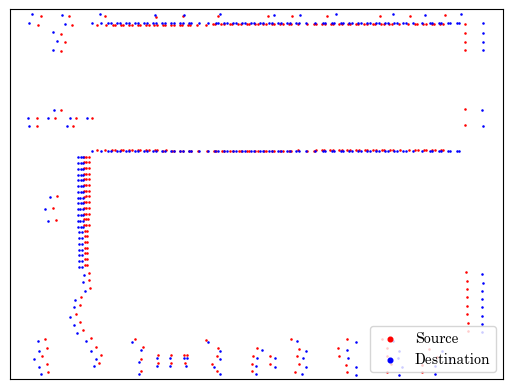

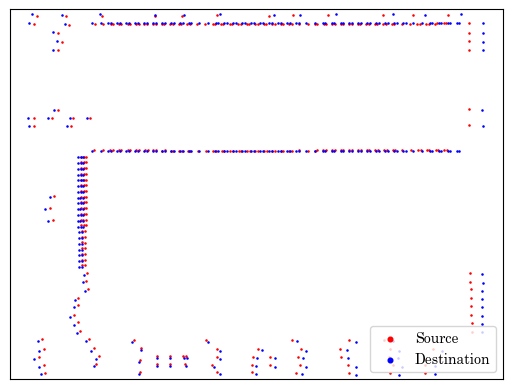

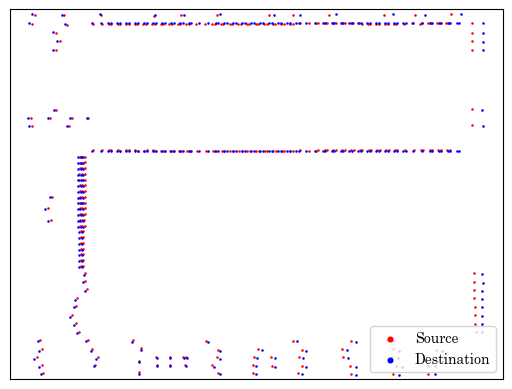

In [ ]:
for i in range(0, len(set_motion)):
    gif_plots(set_motion[i], dst_c, blank, fig_name=i)

Save frames as .gif

In [16]:
frames = []
for i in range(0, 11):
    image = imageio.v2.imread(f'./gif_img/gif_plot_{i}.png')
    frames.append(image)

imageio.mimsave('./RC1_noframe.gif', # output gif
                frames,          # array of input frames
                fps = 5,
                loop = 0) 